In [349]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [350]:
train_df = pd.read_csv(r'./data/train.csv', index_col='Id')
test_df = pd.read_csv(r'./data/test.csv')
# sample_df = pd.read_csv(r'./data/sample_submission.csv')

In [351]:
train_df = train_df.dropna(axis=1)
train_df['MSSubClass'] = train_df['MSSubClass'].astype('object')
train_y = train_df['SalePrice']
train_df = train_df.drop('SalePrice', axis=1)

In [352]:
continuous_features = list(train_df.select_dtypes(include=['int']).columns)
categorical_features  = list(train_df.select_dtypes(include=['object']).columns)

In [353]:
for col in continuous_features:
    train_df[col] = train_df[col].astype('int32')
for col in categorical_features:
    train_df[col] = train_df[col].astype('category')

In [354]:
continuous = np.stack([train_df[col].values for col in continuous_features], 1)
categorical = np.stack([train_df[col].cat.codes.values for col in categorical_features], 1)

In [355]:
y = torch.tensor(train_y.values, dtype=torch.float32).reshape(-1, 1)
continuous = torch.tensor(continuous, dtype=torch.float32)
categorical = torch.tensor(categorical, dtype=torch.int32)

In [356]:
categorical_sizes = [len(train_df[col].cat.categories) for col in categorical_features]
embedding_sizes = [(size, min(50, (size + 1) // 2 )) for size in categorical_sizes]

In [357]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [358]:
torch.manual_seed(33)
model = TabularModel(embedding_sizes, continuous.shape[1], 1, [200,100], p=0.4)

In [359]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
    (4): Embedding(4, 2)
    (5): Embedding(2, 1)
    (6): Embedding(5, 3)
    (7): Embedding(3, 2)
    (8): Embedding(25, 13)
    (9): Embedding(9, 5)
    (10): Embedding(8, 4)
    (11): Embedding(5, 3)
    (12): Embedding(8, 4)
    (13): Embedding(6, 3)
    (14): Embedding(8, 4)
    (15): Embedding(15, 8)
    (16): Embedding(16, 8)
    (17): Embedding(4, 2)
    (18): Embedding(5, 3)
    (19): Embedding(6, 3)
    (20): Embedding(6, 3)
    (21): Embedding(5, 3)
    (22): Embedding(2, 1)
    (23): Embedding(4, 2)
    (24): Embedding(7, 4)
    (25): Embedding(3, 2)
    (26): Embedding(9, 5)
    (27): Embedding(6, 3)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=137, out_features=200, bias=True)
    (1): ReL

In [360]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [361]:
batch_size = 200
test_size = int(batch_size * .2)

cat_train = categorical[:batch_size-test_size]
cat_test = categorical[batch_size-test_size:batch_size]
con_train = continuous[:batch_size-test_size]
con_test = continuous[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [362]:
import time
start_time = time.time()

epochs = 3100
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss.detach().numpy())

    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:   1  loss: 189345.06250000
epoch:  26  loss: 189326.57812500
epoch:  51  loss: 189281.93750000
epoch:  76  loss: 189199.56250000
epoch: 101  loss: 189077.87500000
epoch: 126  loss: 188907.17187500
epoch: 151  loss: 188689.46875000
epoch: 176  loss: 188442.85937500
epoch: 201  loss: 188135.06250000
epoch: 226  loss: 187802.34375000
epoch: 251  loss: 187433.14062500
epoch: 276  loss: 186985.71875000
epoch: 301  loss: 186509.35937500
epoch: 326  loss: 186036.46875000
epoch: 351  loss: 185518.56250000
epoch: 376  loss: 184896.17187500
epoch: 401  loss: 184286.60937500
epoch: 426  loss: 183595.35937500
epoch: 451  loss: 182812.37500000
epoch: 476  loss: 182177.85937500
epoch: 501  loss: 181276.70312500
epoch: 526  loss: 180520.95312500
epoch: 551  loss: 179566.23437500
epoch: 576  loss: 178740.10937500
epoch: 601  loss: 177775.40625000
epoch: 626  loss: 176813.28125000
epoch: 651  loss: 175953.90625000
epoch: 676  loss: 174787.48437500
epoch: 701  loss: 173788.89062500
epoch: 726  lo

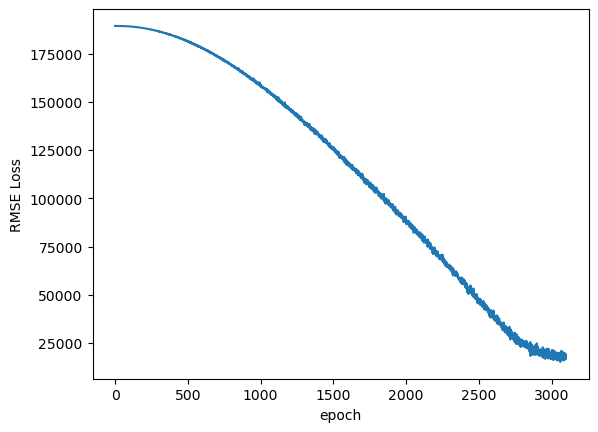

In [363]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');